This notebook is my take on Ben Koger's fruit bat tracking code. I'll need to adapt the parameters and certain parts of the code to get things running. 

### Exported TMC frames 
The TMC frames when exported to PNG results in a 3 channel image with the same pixel values on all channels. 

### Type of image 
The objects need to be *dark* over a bright background. 

In [1]:
import cv2 
import numpy as np
import glob
import os
import pandas as pd
import shutil
import tqdm

import matplotlib.pyplot as plt



In [2]:
%matplotlib notebook

In [3]:
import bat_functions as kbf
#from kbf import simple_process_frame

In [4]:
image_folder = "./thermal_frames/" 

bat_thresh = .2
bat_area = 3

### 2018-07-28 P000 97000.TMC 
For cams K1,2,3

In [ ]:
if not os.path.isdir('tracked_frames/'):
    os.mkdir('tracked_frames/')
all_frame_data = []
for camera_id in ['K1','K2','K3']:

    image_files = sorted(glob.glob(image_folder + f'/*{camera_id}*.png'))

    for focal_frame_ind,_ in tqdm.tqdm(enumerate(image_files)):
        output = kbf.simple_process_frame(image_files, 
                                      bat_thresh, bat_area,
                                      focal_frame_ind)



        frame = cv2.imread(image_files[focal_frame_ind])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        circled_image = kbf.draw_circles_on_image(frame, 
                                              output['bat_centers'], 
                                              output['bat_sizes'], 
                                              rects=output['bat_rects'])

        # save color image with tracking info
        plt.imsave('tracked_frames/'+f'{camera_id}_{focal_frame_ind}_tracked.png', circled_image)
        # save centers of object centres
        df = pd.DataFrame(output['bat_centers'],columns=['col_index','row_index'])
        df['camera_id'] = camera_id
        df['frame_number'] = focal_frame_ind+1
        df['file_name'] = os.path.split(image_files[focal_frame_ind])[-1]
        df['tracking_parameters'] = f'bat_thresh:{bat_thresh};bat_area:{bat_area}'
        all_frame_data.append(df)

all_camera_data = pd.concat(all_frame_data).reset_index(drop=True)

In [ ]:
all_camera_data

### 2018-07-28 P000 35000.TMC 
For cams K1,2,3

In [5]:
image_folder = 'frames_2018-07-28_P00_35000/'
output_dir = 'tracked_frames_2018-07-28_p00_35000/'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

    
all_frame_data_35000 = []
for camera_id in ['K1','K2','K3']:

    image_files = sorted(glob.glob(image_folder + f'/*{camera_id}*.png'))

    for focal_frame_ind,_ in tqdm.tqdm(enumerate(image_files)):
        output = kbf.simple_process_frame(image_files, 
                                      bat_thresh, bat_area,
                                      focal_frame_ind)



        frame = cv2.imread(image_files[focal_frame_ind])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        circled_image = kbf.draw_circles_on_image(frame, 
                                              output['bat_centers'], 
                                              output['bat_sizes'], 
                                              rects=output['bat_rects'])

        # save color image with tracking info
        plt.imsave(output_dir+f'{camera_id}_{focal_frame_ind}_tracked.png', circled_image)
        # save centers of object centres
        df = pd.DataFrame(output['bat_centers'],columns=['col_index','row_index'])
        df['camera_id'] = camera_id
        df['frame_number'] = focal_frame_ind+1
        df['file_name'] = os.path.split(image_files[focal_frame_ind])[-1]
        df['tracking_parameters'] = f'bat_thresh:{bat_thresh};bat_area:{bat_area}'
        all_frame_data_35000.append(df)

all_camera_data_35000 = pd.concat(all_frame_data_35000).reset_index(drop=True)

75it [00:45,  1.66it/s]
75it [00:45,  1.65it/s]
75it [00:45,  1.66it/s]


<IPython.core.display.Javascript object>


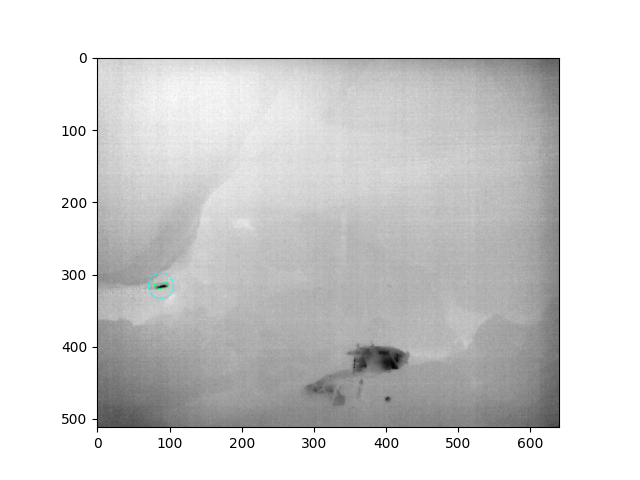

In [6]:
plt.figure()
plt.imshow(circled_image)